# Poisson Upstream

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mutual_info_markov_funcs import (rates_from_params,
                                mutual_information_calc,
                                two_state_system_dt, 
                                two_state_system_detection_dt,
                                steady_state_sim,
                                steady_state_when_event_occurs,
                                survival_probabilities_given_initial_state,
                                compute_prob_time_since_last_event,
                                death_event_probs,
                                prob_x_given_detection_t_and_init,
                                numerical_mutual_info_onestep_vectorized,
                                numerical_mutual_info_onestep_vectorized_with_init,
                                fast_numerical_mutual_info_twostep,
                                fast_numerical_mutual_info_twostep_with_init)

from mutual_info_markov_funcs import (birth_death_system,
                                poisson_steady_state_sim,
                                poisson_birth_death_detection_dt, 
                                poisson_survival_probabilities)

# Define rates
N = 10.0  # Fixed occupation number
A_values = np.logspace(1.0, 1.2, 2)  # Range of alpha values to test

# Time parameters
t_max = 10.0  # Total simulation time
dt = 0.05  # Time step size (user can adjust)
t_eval = np.arange(0, t_max, dt)

# Simulation parameters
max_n = (int)(3*N) + 5
initial_p = np.zeros(max_n + 1)
initial_p[int(N)] = 1.0
num_states = max_n + 1

# Storage for results (modified with _poisson suffix)
mutual_infos_fast_num_poisson = []
mutual_infos_fast_num_with_init_poisson = []
mutual_infos_fast_num_2step_poisson = []
mutual_infos_fast_num_2step_with_init_poisson = []

def poisson_rates_from_params(N, A):
    μ = 1.0
    λ = N  # Fixed typo: was N = λ, should be λ = N
    α = A
    return λ, μ, α

# Calculate mutual information for each alpha
for A in A_values:
    # Convert parameters to rates
    λ, μ, α = poisson_rates_from_params(N, A)
    
    # Obtain PDFs
    steady_state = poisson_steady_state_sim(birth_death_system, initial_p, t_max, dt, λ, μ, max_n)
    initial_state = steady_state_when_event_occurs(steady_state)
    
    # Time dependent evolution
    solution = poisson_survival_probabilities(poisson_birth_death_detection_dt, num_states, t_max, dt, λ, μ, α)
    # A couple derived PDFs from the time evolution
    prob_time_since_last_event = compute_prob_time_since_last_event(solution, dt)
    death_probs = death_event_probs(solution, dt)
    prob_x_given_t_and_init = prob_x_given_detection_t_and_init(solution)

    #print (steady_state.shape)
    #print (initial_state.shape)
    #print (solution.shape)
    #print (prob_time_since_last_event.shape)
    #print (death_probs.shape)
    #print (prob_x_given_t_and_init.shape)
    mask_x = steady_state > 0
    x_ent = -np.sum(steady_state[mask_x] * np.log2(steady_state[mask_x]))
    
    # Fast vectorized calculations
    fast_joint_entropy, fast_time_entropy = numerical_mutual_info_onestep_vectorized(t_eval, dt, initial_state, prob_time_since_last_event)
    fast_mi_numeric = fast_time_entropy + x_ent - fast_joint_entropy
    mutual_infos_fast_num_poisson.append(fast_mi_numeric)
    
    fast_joint_entropy_init, fast_time_entropy_init = numerical_mutual_info_onestep_vectorized_with_init(t_eval, dt, initial_state, prob_time_since_last_event)
    fast_mi_numeric_init = fast_time_entropy_init + x_ent - fast_joint_entropy_init
    mutual_infos_fast_num_with_init_poisson.append(fast_mi_numeric_init)

    fast_joint_entropy_2step, fast_time_entropy_2step = fast_numerical_mutual_info_twostep(t_eval, dt, initial_state, prob_time_since_last_event, death_probs, prob_x_given_t_and_init, chunk_size=10)
    fast_mi_numeric_2step = fast_time_entropy_2step + x_ent - fast_joint_entropy_2step
    mutual_infos_fast_num_2step_poisson.append(fast_mi_numeric_2step)

    fast_joint_entropy_2step_init, fast_time_entropy_2step_init = fast_numerical_mutual_info_twostep_with_init(t_eval, dt, initial_state, prob_time_since_last_event, death_probs, prob_x_given_t_and_init, chunk_size=10)
    fast_mi_numeric_2step_init = fast_time_entropy_2step_init + x_ent - fast_joint_entropy_2step_init
    mutual_infos_fast_num_2step_with_init_poisson.append(fast_mi_numeric_2step_init)

print("Done calculations!")

Done calculations!


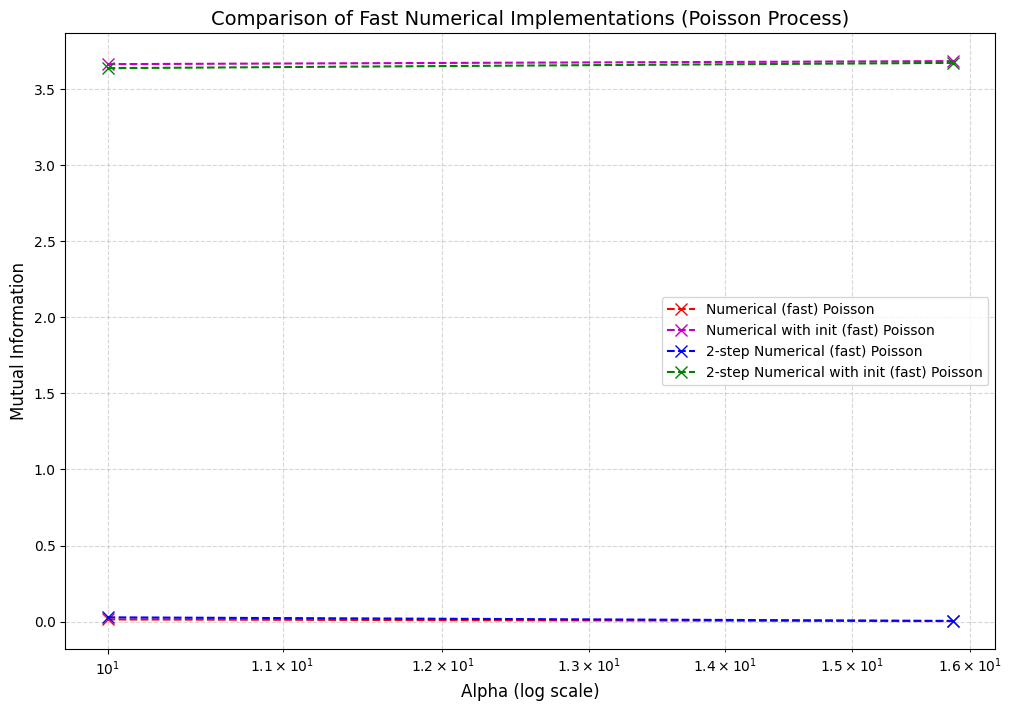

In [4]:
# Plot comparison between original and fast versions (Poisson case)
plt.figure(figsize=(12, 8))
plt.semilogx(A_values, mutual_infos_fast_num_poisson, 'rx--', label='Numerical (fast) Poisson', markersize=8)
plt.semilogx(A_values, mutual_infos_fast_num_with_init_poisson, 'mx--', label='Numerical with init (fast) Poisson', markersize=8)
plt.semilogx(A_values, mutual_infos_fast_num_2step_poisson, 'bx--', label='2-step Numerical (fast) Poisson', markersize=8)
plt.semilogx(A_values, mutual_infos_fast_num_2step_with_init_poisson, 'gx--', label='2-step Numerical with init (fast) Poisson', markersize=8)
plt.xlabel('Alpha (log scale)', fontsize=12)
plt.ylabel('Mutual Information', fontsize=12)
plt.title('Comparison of Fast Numerical Implementations (Poisson Process)', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.show()

In [5]:
print (mutual_infos_fast_num_poisson)
print (mutual_infos_fast_num_with_init_poisson)
print (mutual_infos_fast_num_2step_poisson)
print (mutual_infos_fast_num_2step_with_init_poisson)

[np.float64(0.014023918377361055), np.float64(0.0029617855116123026)]
[np.float64(3.6641217965853987), np.float64(3.6839242059965067)]
[np.float64(0.02773627281384261), np.float64(0.004440928330795124)]
[np.float64(3.6376627425272305), np.float64(3.6723541640442994)]


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mutual_info_markov_funcs import (rates_from_params,
                                mutual_information_calc,
                                two_state_system_dt, 
                                two_state_system_detection_dt,
                                steady_state_sim,
                                steady_state_when_event_occurs,
                                survival_probabilities_given_initial_state,
                                compute_prob_time_since_last_event,
                                death_event_probs,
                                prob_x_given_detection_t_and_init,
                                numerical_mutual_info_onestep_vectorized,
                                numerical_mutual_info_onestep_vectorized_with_init,
                                fast_numerical_mutual_info_twostep,
                                fast_numerical_mutual_info_twostep_with_init)

from mutual_info_markov_funcs import (birth_death_system,
                                poisson_steady_state_sim,
                                poisson_birth_death_detection_dt, 
                                poisson_survival_probabilities)

# Define rates
N = 10.0  # Fixed occupation number
A_values = np.logspace(1.0, 1.2, 2)  # Range of alpha values to test

# Time parameters
t_max = 10.0  # Total simulation time
dt = 0.01  # Time step size (user can adjust)
t_eval = np.arange(0, t_max, dt)

# Simulation parameters
max_n = (int)(3*N) + 5
initial_p = np.zeros(max_n + 1)
initial_p[int(N)] = 1.0
num_states = max_n + 1

# Storage for results (modified with _poisson suffix)
mutual_infos_fast_num_poisson = []
mutual_infos_fast_num_with_init_poisson = []
mutual_infos_fast_num_2step_poisson = []
mutual_infos_fast_num_2step_with_init_poisson = []

def poisson_rates_from_params(N, A):
    μ = 1.0
    λ = N  # Fixed typo: was N = λ, should be λ = N
    α = A
    return λ, μ, α

# Calculate mutual information for each alpha
for A in A_values:
    # Convert parameters to rates
    λ, μ, α = poisson_rates_from_params(N, A)
    
    # Obtain PDFs
    steady_state = poisson_steady_state_sim(birth_death_system, initial_p, t_max, dt, λ, μ, max_n)
    initial_state = steady_state_when_event_occurs(steady_state)
    
    # Time dependent evolution
    solution = poisson_survival_probabilities(poisson_birth_death_detection_dt, num_states, t_max, dt, λ, μ, α)
    # A couple derived PDFs from the time evolution
    prob_time_since_last_event = compute_prob_time_since_last_event(solution, dt)
    death_probs = death_event_probs(solution, dt)
    prob_x_given_t_and_init = prob_x_given_detection_t_and_init(solution)

    #print (steady_state.shape)
    #print (initial_state.shape)
    #print (solution.shape)
    #print (prob_time_since_last_event.shape)
    #print (death_probs.shape)
    #print (prob_x_given_t_and_init.shape)
    mask_x = steady_state > 0
    x_ent = -np.sum(steady_state[mask_x] * np.log2(steady_state[mask_x]))
    
    # Fast vectorized calculations
    fast_joint_entropy, fast_time_entropy = numerical_mutual_info_onestep_vectorized(t_eval, dt, initial_state, prob_time_since_last_event)
    fast_mi_numeric = fast_time_entropy + x_ent - fast_joint_entropy
    mutual_infos_fast_num_poisson.append(fast_mi_numeric)
    
    fast_joint_entropy_init, fast_time_entropy_init = numerical_mutual_info_onestep_vectorized_with_init(t_eval, dt, initial_state, prob_time_since_last_event)
    fast_mi_numeric_init = fast_time_entropy_init + x_ent - fast_joint_entropy_init
    mutual_infos_fast_num_with_init_poisson.append(fast_mi_numeric_init)

    fast_joint_entropy_2step, fast_time_entropy_2step = fast_numerical_mutual_info_twostep(t_eval, dt, initial_state, prob_time_since_last_event, death_probs, prob_x_given_t_and_init, chunk_size=10)
    fast_mi_numeric_2step = fast_time_entropy_2step + x_ent - fast_joint_entropy_2step
    mutual_infos_fast_num_2step_poisson.append(fast_mi_numeric_2step)

    fast_joint_entropy_2step_init, fast_time_entropy_2step_init = fast_numerical_mutual_info_twostep_with_init(t_eval, dt, initial_state, prob_time_since_last_event, death_probs, prob_x_given_t_and_init, chunk_size=10)
    fast_mi_numeric_2step_init = fast_time_entropy_2step_init + x_ent - fast_joint_entropy_2step_init
    mutual_infos_fast_num_2step_with_init_poisson.append(fast_mi_numeric_2step_init)

print("Done calculations!")

Done calculations!


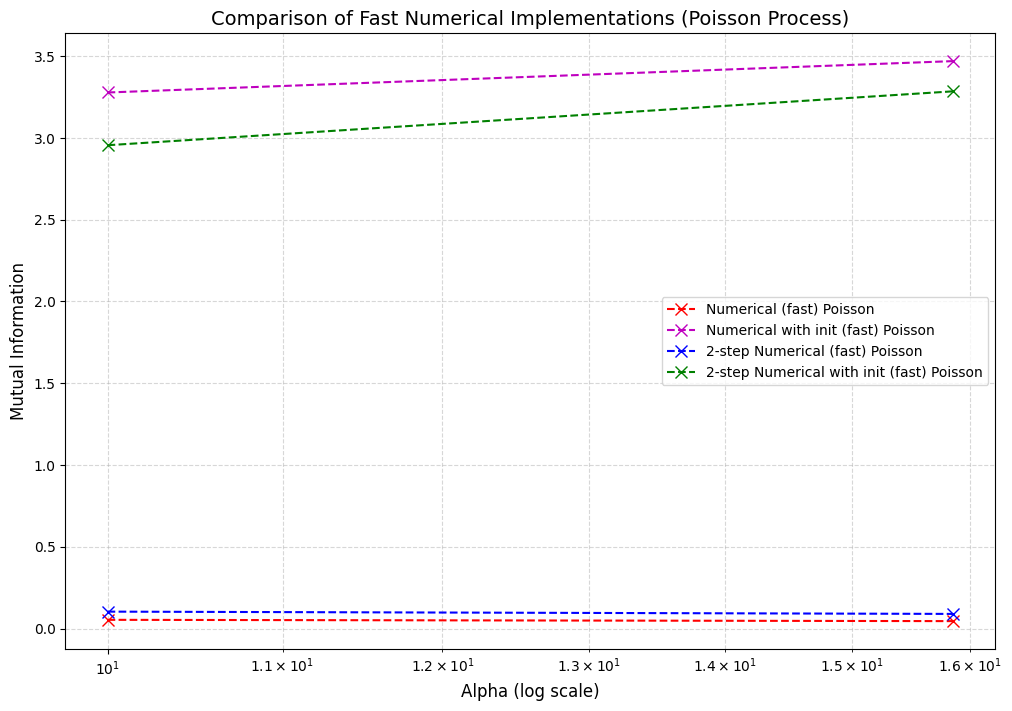

[np.float64(0.053343876297248016), np.float64(0.045414989466069144)]
[np.float64(3.277302427538545), np.float64(3.4691129873286703)]
[np.float64(0.10345429738593115), np.float64(0.08945135244006064)]
[np.float64(2.9549198408263195), np.float64(3.2844344488413517)]


In [7]:
# Plot comparison between original and fast versions (Poisson case)
plt.figure(figsize=(12, 8))
plt.semilogx(A_values, mutual_infos_fast_num_poisson, 'rx--', label='Numerical (fast) Poisson', markersize=8)
plt.semilogx(A_values, mutual_infos_fast_num_with_init_poisson, 'mx--', label='Numerical with init (fast) Poisson', markersize=8)
plt.semilogx(A_values, mutual_infos_fast_num_2step_poisson, 'bx--', label='2-step Numerical (fast) Poisson', markersize=8)
plt.semilogx(A_values, mutual_infos_fast_num_2step_with_init_poisson, 'gx--', label='2-step Numerical with init (fast) Poisson', markersize=8)
plt.xlabel('Alpha (log scale)', fontsize=12)
plt.ylabel('Mutual Information', fontsize=12)
plt.title('Comparison of Fast Numerical Implementations (Poisson Process)', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.show()

print (mutual_infos_fast_num_poisson)
print (mutual_infos_fast_num_with_init_poisson)
print (mutual_infos_fast_num_2step_poisson)
print (mutual_infos_fast_num_2step_with_init_poisson)

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mutual_info_markov_funcs import (rates_from_params,
                                mutual_information_calc,
                                two_state_system_dt, 
                                two_state_system_detection_dt,
                                steady_state_sim,
                                steady_state_when_event_occurs,
                                survival_probabilities_given_initial_state,
                                compute_prob_time_since_last_event,
                                death_event_probs,
                                prob_x_given_detection_t_and_init,
                                numerical_mutual_info_onestep_vectorized,
                                numerical_mutual_info_onestep_vectorized_with_init,
                                fast_numerical_mutual_info_twostep,
                                fast_numerical_mutual_info_twostep_with_init)

from mutual_info_markov_funcs import (birth_death_system,
                                poisson_steady_state_sim,
                                poisson_birth_death_detection_dt, 
                                poisson_survival_probabilities)

# Define rates
N = 10.0  # Fixed occupation number
A_values = np.logspace(1.0, 1.2, 1)  # Range of alpha values to test

# Time parameters
t_max = 5.0  # Total simulation time
dt = 0.005  # Time step size (user can adjust)
t_eval = np.arange(0, t_max, dt)

# Simulation parameters
max_n = (int)(3*N) + 5
initial_p = np.zeros(max_n + 1)
initial_p[int(N)] = 1.0
num_states = max_n + 1

# Storage for results (modified with _poisson suffix)
mutual_infos_fast_num_poisson = []
mutual_infos_fast_num_with_init_poisson = []
mutual_infos_fast_num_2step_poisson = []
mutual_infos_fast_num_2step_with_init_poisson = []

def poisson_rates_from_params(N, A):
    μ = 1.0
    λ = N  # Fixed typo: was N = λ, should be λ = N
    α = A
    return λ, μ, α

# Calculate mutual information for each alpha
for A in A_values:
    # Convert parameters to rates
    λ, μ, α = poisson_rates_from_params(N, A)
    
    # Obtain PDFs
    steady_state = poisson_steady_state_sim(birth_death_system, initial_p, t_max, dt, λ, μ, max_n)
    initial_state = steady_state_when_event_occurs(steady_state)
    
    # Time dependent evolution
    solution = poisson_survival_probabilities(poisson_birth_death_detection_dt, num_states, t_max, dt, λ, μ, α)
    # A couple derived PDFs from the time evolution
    prob_time_since_last_event = compute_prob_time_since_last_event(solution, dt)
    death_probs = death_event_probs(solution, dt)
    prob_x_given_t_and_init = prob_x_given_detection_t_and_init(solution)

    #print (steady_state.shape)
    #print (initial_state.shape)
    #print (solution.shape)
    #print (prob_time_since_last_event.shape)
    #print (death_probs.shape)
    #print (prob_x_given_t_and_init.shape)
    mask_x = steady_state > 0
    x_ent = -np.sum(steady_state[mask_x] * np.log2(steady_state[mask_x]))
    
    # Fast vectorized calculations
    fast_joint_entropy, fast_time_entropy = numerical_mutual_info_onestep_vectorized(t_eval, dt, initial_state, prob_time_since_last_event)
    fast_mi_numeric = fast_time_entropy + x_ent - fast_joint_entropy
    mutual_infos_fast_num_poisson.append(fast_mi_numeric)
    
    fast_joint_entropy_init, fast_time_entropy_init = numerical_mutual_info_onestep_vectorized_with_init(t_eval, dt, initial_state, prob_time_since_last_event)
    fast_mi_numeric_init = fast_time_entropy_init + x_ent - fast_joint_entropy_init
    mutual_infos_fast_num_with_init_poisson.append(fast_mi_numeric_init)

    fast_joint_entropy_2step, fast_time_entropy_2step = fast_numerical_mutual_info_twostep(t_eval, dt, initial_state, prob_time_since_last_event, death_probs, prob_x_given_t_and_init, chunk_size=10)
    fast_mi_numeric_2step = fast_time_entropy_2step + x_ent - fast_joint_entropy_2step
    mutual_infos_fast_num_2step_poisson.append(fast_mi_numeric_2step)

    fast_joint_entropy_2step_init, fast_time_entropy_2step_init = fast_numerical_mutual_info_twostep_with_init(t_eval, dt, initial_state, prob_time_since_last_event, death_probs, prob_x_given_t_and_init, chunk_size=10)
    fast_mi_numeric_2step_init = fast_time_entropy_2step_init + x_ent - fast_joint_entropy_2step_init
    mutual_infos_fast_num_2step_with_init_poisson.append(fast_mi_numeric_2step_init)

print("Done calculations!")

Done calculations!


ValueError: x and y must have same first dimension, but have shapes (1,) and (0,)

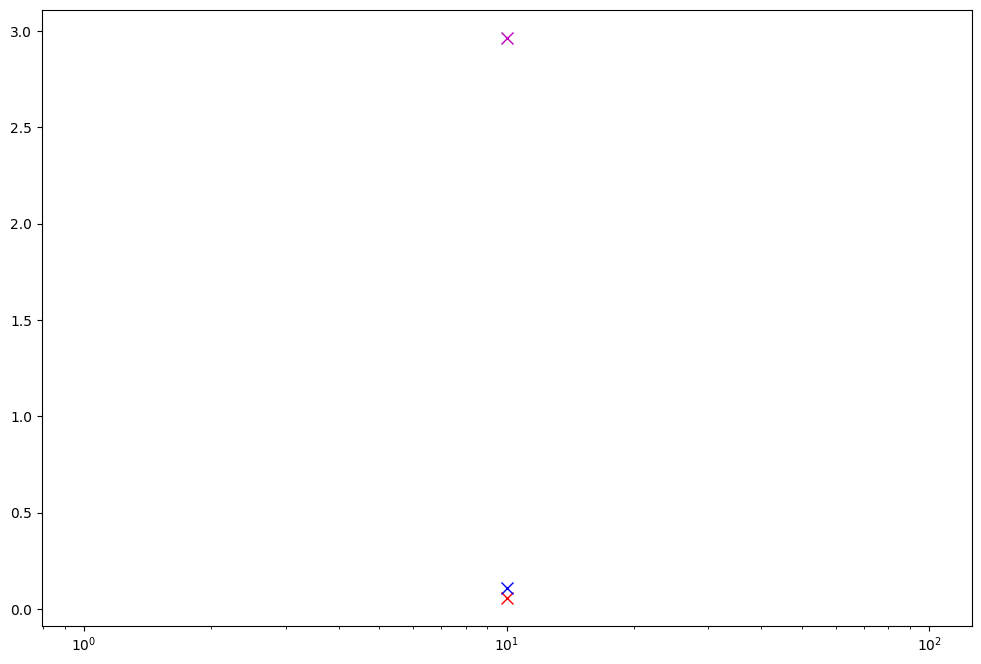

In [13]:
# Plot comparison between original and fast versions (Poisson case)
plt.figure(figsize=(12, 8))
plt.semilogx(A_values, mutual_infos_fast_num_poisson, 'rx--', label='Numerical (fast) Poisson', markersize=8)
plt.semilogx(A_values, mutual_infos_fast_num_with_init_poisson, 'mx--', label='Numerical with init (fast) Poisson', markersize=8)
plt.semilogx(A_values, mutual_infos_fast_num_2step_poisson, 'bx--', label='2-step Numerical (fast) Poisson', markersize=8)
plt.semilogx(A_values, mutual_infos_fast_num_2step_with_init_poisson, 'gx--', label='2-step Numerical with init (fast) Poisson', markersize=8)
plt.xlabel('Alpha (log scale)', fontsize=12)
plt.ylabel('Mutual Information', fontsize=12)
plt.title('Comparison of Fast Numerical Implementations (Poisson Process)', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.show()

print (mutual_infos_fast_num_poisson)
print (mutual_infos_fast_num_with_init_poisson)
print (mutual_infos_fast_num_2step_poisson)
print (mutual_infos_fast_num_2step_with_init_poisson)
print (ent_x)

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from mutual_info_markov_funcs import (rates_from_params,
                                mutual_information_calc,
                                two_state_system_dt, 
                                two_state_system_detection_dt,
                                steady_state_sim,
                                steady_state_when_event_occurs,
                                survival_probabilities_given_initial_state,
                                compute_prob_time_since_last_event,
                                death_event_probs,
                                prob_x_given_detection_t_and_init,
                                numerical_mutual_info_onestep_vectorized,
                                numerical_mutual_info_onestep_vectorized_with_init,
                                fast_numerical_mutual_info_twostep,
                                fast_numerical_mutual_info_twostep_with_init)

from mutual_info_markov_funcs import (birth_death_system,
                                poisson_steady_state_sim,
                                poisson_birth_death_detection_dt, 
                                poisson_survival_probabilities)

# Define rates
N = 10.0  # Fixed occupation number
A_values = np.logspace(1.0, 1.2, 1)  # Range of alpha values to test

# Time parameters
t_max = 2.0  # Total simulation time
dt = 0.005  # Time step size (user can adjust)
t_eval = np.arange(0, t_max, dt)

# Simulation parameters
max_n = (int)(3*N) + 5
initial_p = np.zeros(max_n + 1)
initial_p[int(N)] = 1.0
num_states = max_n + 1

# Storage for results (modified with _poisson suffix)
mutual_infos_fast_num_poisson = []
mutual_infos_fast_num_with_init_poisson = []
mutual_infos_fast_num_2step_poisson = []
mutual_infos_fast_num_2step_with_init_poisson = []

def poisson_entropy(lam=10, cutoff_prob=1e-10):
    """
    Compute the entropy of a Poisson distribution with parameter lambda.
    
    Args:
        lam: Mean of the Poisson distribution (default=10)
        cutoff_prob: Stop when probabilities fall below this value (default=1e-10)
    
    Returns:
        Entropy in nats (natural units)
    """
    entropy = 0.0
    k = 0
    while True:
        p = poisson.pmf(k, lam)
        if p < cutoff_prob and k > lam:  # Stop when probability becomes negligible
            break
        if p > 0:
            entropy -= xlogy(p, p)  # Equivalent to -p * log(p) but handles p=0 correctly
        k += 1
    
    return entropy

def poisson_rates_from_params(N, A):
    μ = 1.0
    λ = N  # Fixed typo: was N = λ, should be λ = N
    α = A
    return λ, μ, α

x_ent = poisson_entropy(N)
# Calculate mutual information for each alpha
for A in A_values:
    # Convert parameters to rates
    λ, μ, α = poisson_rates_from_params(N, A)
    
    # Obtain PDFs
    steady_state = poisson_steady_state_sim(birth_death_system, initial_p, 100, dt, λ, μ, max_n)
    initial_state = steady_state_when_event_occurs(steady_state)
    
    # Time dependent evolution
    solution = poisson_survival_probabilities(poisson_birth_death_detection_dt, num_states, t_max, dt, λ, μ, α)
    # A couple derived PDFs from the time evolution
    prob_time_since_last_event = compute_prob_time_since_last_event(solution, dt)
    death_probs = death_event_probs(solution, dt)
    prob_x_given_t_and_init = prob_x_given_detection_t_and_init(solution)

    #print (steady_state.shape)
    #print (initial_state.shape)
    #print (solution.shape)
    #print (prob_time_since_last_event.shape)
    #print (death_probs.shape)
    #print (prob_x_given_t_and_init.shape)
    mask_x = steady_state > 0
    x_ent = -np.sum(steady_state[mask_x] * np.log2(steady_state[mask_x]))
    
    # Fast vectorized calculations
    fast_joint_entropy, fast_time_entropy = numerical_mutual_info_onestep_vectorized(t_eval, dt, initial_state, prob_time_since_last_event)
    fast_mi_numeric = fast_time_entropy + x_ent - fast_joint_entropy
    mutual_infos_fast_num_poisson.append(fast_mi_numeric)
    
    fast_joint_entropy_init, fast_time_entropy_init = numerical_mutual_info_onestep_vectorized_with_init(t_eval, dt, initial_state, prob_time_since_last_event)
    fast_mi_numeric_init = fast_time_entropy_init + x_ent - fast_joint_entropy_init
    mutual_infos_fast_num_with_init_poisson.append(fast_mi_numeric_init)

    fast_joint_entropy_2step, fast_time_entropy_2step = fast_numerical_mutual_info_twostep(t_eval, dt, initial_state, prob_time_since_last_event, death_probs, prob_x_given_t_and_init, chunk_size=10)
    fast_mi_numeric_2step = fast_time_entropy_2step + x_ent - fast_joint_entropy_2step
    mutual_infos_fast_num_2step_poisson.append(fast_mi_numeric_2step)

    fast_joint_entropy_2step_init, fast_time_entropy_2step_init = fast_numerical_mutual_info_twostep_with_init(t_eval, dt, initial_state, prob_time_since_last_event, death_probs, prob_x_given_t_and_init, chunk_size=10)
    fast_mi_numeric_2step_init = fast_time_entropy_2step_init + x_ent - fast_joint_entropy_2step_init
    mutual_infos_fast_num_2step_with_init_poisson.append(fast_mi_numeric_2step_init)

print (x_ent)
print (fast_time_entropy_2step_init)
print (fast_joint_entropy_2step_init)

print("Done calculations!")

KeyboardInterrupt: 

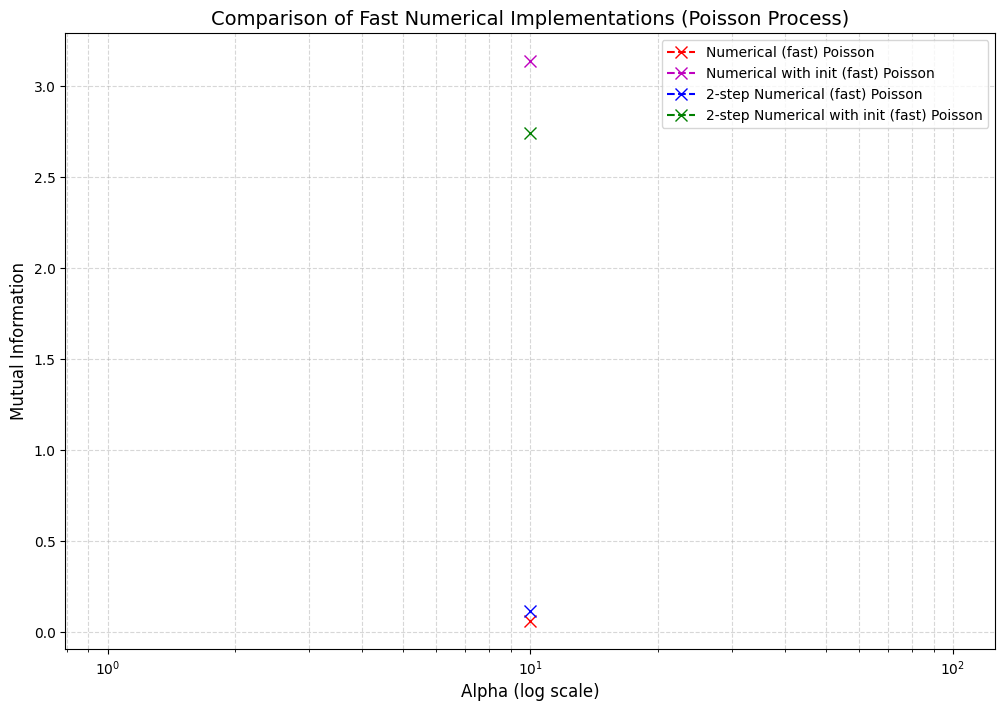

-10.38324654057447
-6.801791808345297
[np.float64(0.05958787586371184)]
[np.float64(3.136037219519894)]
[np.float64(0.11393628367706299)]
[np.float64(2.741784468792405)]


In [31]:
# Plot comparison between original and fast versions (Poisson case)
plt.figure(figsize=(12, 8))
plt.semilogx(A_values, mutual_infos_fast_num_poisson, 'rx--', label='Numerical (fast) Poisson', markersize=8)
plt.semilogx(A_values, mutual_infos_fast_num_with_init_poisson, 'mx--', label='Numerical with init (fast) Poisson', markersize=8)
plt.semilogx(A_values, mutual_infos_fast_num_2step_poisson, 'bx--', label='2-step Numerical (fast) Poisson', markersize=8)
plt.semilogx(A_values, mutual_infos_fast_num_2step_with_init_poisson, 'gx--', label='2-step Numerical with init (fast) Poisson', markersize=8)
plt.xlabel('Alpha (log scale)', fontsize=12)
plt.ylabel('Mutual Information', fontsize=12)
plt.title('Comparison of Fast Numerical Implementations (Poisson Process)', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.show()

print (fast_time_entropy_2step)
print (fast_joint_entropy_2step)

print (mutual_infos_fast_num_poisson)
print (mutual_infos_fast_num_with_init_poisson)
print (mutual_infos_fast_num_2step_poisson)
print (mutual_infos_fast_num_2step_with_init_poisson)

In [29]:
mask_x = steady_state > 0
x_ent = -np.sum(steady_state[mask_x] * np.log2(steady_state[mask_x]))
print (x_ent)
print (steady_state)
print (np.sum(steady_state))

3.695391015906236
[ 4.53999298e-05  4.53999298e-04  2.26999649e-03  7.56665496e-03
  1.89166374e-02  3.78332748e-02  6.30554580e-02  9.00792257e-02
  1.12599032e-01  1.25110036e-01  1.25110036e-01  1.13736396e-01
  9.47803301e-02  7.29079461e-02  5.20771048e-02  3.47180686e-02
  2.16987966e-02  1.27639878e-02  7.09112981e-03  3.73211498e-03
  1.86618170e-03  8.88415302e-04  4.04262262e-04  1.75040032e-04
  7.40452735e-05  2.80503531e-05  1.28205589e-05  2.33344271e-06
  3.45567961e-06 -1.39696837e-06  1.84045005e-06 -1.24051711e-06
  8.92851255e-07 -4.91182936e-07  2.18625797e-07 -5.31530258e-08]
1.0000000000000004


In [24]:
import numpy as np
from scipy.stats import poisson

def print_poisson_distribution(lam=10, max_k=100):
    """
    Print the Poisson distribution probabilities for given lambda up to max_k.
    
    Parameters:
    lam (float): Mean of the Poisson distribution (default=10)
    max_k (int): Maximum value to print (default=100)
    """
    print(f"Poisson Distribution (λ={lam}) Probabilities:")
    print(f"{'k':<5}{'P(X=k)':<15}{'Cumulative':<15}")
    print("-"*35)
    
    k_values = np.arange(0, max_k + 1)
    probs = poisson.pmf(k_values, lam)
    cum_probs = poisson.cdf(k_values, lam)
    
    for k, prob, cum_prob in zip(k_values, probs, cum_probs):
        print(f"{k:<5}{prob:<15.6g}{cum_prob:<15.6g}")
        if k >= 30 and prob < 1e-6:  # Early stopping for very small probabilities
            print(f"... (probabilities < 1e-6 beyond k={k})")
            break

# Example usage:
print_poisson_distribution(lam=10, max_k=100)

Poisson Distribution (λ=10) Probabilities:
k    P(X=k)         Cumulative     
-----------------------------------
0    4.53999e-05    4.53999e-05    
1    0.000453999    0.000499399    
2    0.00227        0.0027694      
3    0.00756665     0.0103361      
4    0.0189166      0.0292527      
5    0.0378333      0.067086       
6    0.0630555      0.130141       
7    0.0900792      0.220221       
8    0.112599       0.33282        
9    0.12511        0.45793        
10   0.12511        0.58304        
11   0.113736       0.696776       
12   0.0947803      0.791556       
13   0.0729079      0.864464       
14   0.0520771      0.916542       
15   0.0347181      0.95126        
16   0.0216988      0.972958       
17   0.012764       0.985722       
18   0.00709111     0.992813       
19   0.00373216     0.996546       
20   0.00186608     0.998412       
21   0.00088861     0.9993         
22   0.000403914    0.999704       
23   0.000175615    0.99988        
24   7.31728e-05    0

In [33]:
def poisson_entropy(lam=10, cutoff_prob=1e-10):
    """
    Compute the entropy of a Poisson distribution with parameter lambda.
    
    Args:
        lam: Mean of the Poisson distribution (default=10)
        cutoff_prob: Stop when probabilities fall below this value (default=1e-10)
    
    Returns:
        Entropy in nats (natural units)
    """
    entropy = 0.0
    k = 0
    while True:
        p = poisson.pmf(k, lam)
        if p < cutoff_prob and k > lam:  # Stop when probability becomes negligible
            break
        if p > 0:
            entropy -= p*np.log2(p)  # Equivalent to -p * log(p) but handles p=0 correctly
        k += 1
    
    return entropy

# Compute and display the entropy
lambda_val = 10
entropy = poisson_entropy(lambda_val)
print(f"Entropy of Poisson(λ={lambda_val}) distribution: {entropy:.6f} nats")

# Verification: Compare with large lambda approximation
approx_entropy = 0.5 * np.log(2 * np.pi * np.e * lambda_val)
print(f"Large lambda approximation: {approx_entropy:.6f} nats")
print(f"Difference: {abs(entropy - approx_entropy):.6f} nats")

Entropy of Poisson(λ=10) distribution: 3.695333 nats
Large lambda approximation: 2.570231 nats
Difference: 1.125102 nats
